#### 1. Fundamentos do Projeto e Setup Inicial

O objetivo do projeto é criar um modelo robusto que minimiza as fraquezas de cada método de recomendação, resultando em um Modelo Híbrido.

1.1. Importações e Bibliotecas
Esta seção carrega as ferramentas necessárias:

surprise: A biblioteca principal para Filtragem Colaborativa (CF), que fornece algoritmos como SVD.

sklearn (Scikit-learn): Usada para a parte Baseada em Conteúdo, especificamente para TfidfVectorizer e linear_kernel (similaridade de cossenos).

pandas e numpy: Para manipulação e cálculo de dados.

In [1]:
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

1.2. Função de Avaliação (precision_recall_at_k)
Esta função é uma métrica crucial para avaliar a eficácia das recomendações Top-N (listas de recomendação).

Precision@k: Responde: Dos $k$ filmes recomendados, quantos o usuário realmente gostou (avaliou $\ge 4.0$)

?Recall@k: Responde: Dos filmes que o usuário gostou, quantos foram incluídos nos $k$ recomendados?

O threshold=4.0 define que um filme é considerado "relevante" se a nota real do usuário for $4.0$ ou superior.

In [2]:
# FUNÇÃO DE AVALIAÇÃO (PRECISION/RECALL)

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    """
    Retorna a precision e recall médios em k para todos os usuários.
    """

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rec_k = k
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return sum(p for p in precisions.values()) / len(precisions), \
           sum(r for r in recalls.values()) / len(recalls)

1.3. Carregamento e Preparação dos Dados

Esta parte faz a leitura dos dados e a limpeza essencial para ambos os modelos:

ratings_df: Contém as avaliações (userId, movieId, rating). Usado para o modelo SVD.

movies_df: Contém metadados dos filmes (movieId, title, genres). Usado para o modelo Baseado em Conteúdo.

title_clean: Cria títulos sem o ano, essencial para padronizar.

rich_content: Atualmente, usa apenas gêneros separados por espaço (genres_space_separated). Esta é a coluna que você enriqueceria com sinopses ou atores para melhorar a precisão da parte de Conteúdo.

data: Objeto Dataset da surprise que encapsula o ratings_df para ser usado no treinamento do SVD.

In [3]:
ratings_df = pd.read_csv(r'../data/data_output/ratings_processed.csv')
movies_df = pd.read_csv(r'../data/data_output/movies_processed.csv')

# Preparação de colunas para Conteúdo (Garantir title_clean e genres_space_separated)
if 'title_clean' not in movies_df.columns:
    # Remove o ano do título (ex: 'Toy Story (1995)' -> 'Toy Story')
    movies_df['title_clean'] = movies_df['title'].str.replace(r' \(\d{4}\)$', '', regex=True).str.strip()
    
# Coluna de Gêneros separada por espaço para o TF-IDF
movies_df['genres_space_separated'] = movies_df['genres'].str.replace('|', ' ', regex=False)

# Adicionar uma coluna de "Conteúdo Rico" (Aqui você adicionaria sinopses, atores, etc. se tivesse)
# Exemplo: movies_df['rich_content'] = movies_df['genres_space_separated'] + ' ' + movies_df['director_name']
movies_df['rich_content'] = movies_df['genres_space_separated']

# Configuração do Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

2.Filtragem Colaborativa (SVD) - Base Forte

O SVD (Singular Value Decomposition) é um algoritmo de Fatoração de Matriz que descobre fatores latentes (características não observáveis) que explicam as interações entre usuários e itens. Ele é o coração do seu sistema.

2.1. Otimização e Treinamento (GridSearchCV)
Esta seção é focada em encontrar os melhores hiperparâmetros para o algoritmo SVD:

param_grid: Define o espaço de busca para os hiperparâmetros:

n_factors (Fatores Latentes): Quantas "dimensões" o modelo usará para representar gostos e características dos filmes.

n_epochs (Iterações): Quantas vezes o algoritmo deve passar por todo o dataset de treino.

lr_all (Taxa de Aprendizado): Quão rápido o modelo ajusta seus parâmetros a cada iteração.

reg_all (Regularização): Uma técnica para evitar overfitting (decoração de dados).

GridSearchCV: É uma técnica de busca exaustiva que testa todas as combinações de parâmetros no param_grid usando validação cruzada (cv=3) para encontrar a combinação que resulta no menor RMSE (Root Mean Squared Error) e MAE (Mean Absolute Error).

Treinamento Definitivo: O modelo algo_svd_otimizado é treinado com os melhores parâmetros encontrados (best_params) usando todo o conjunto de dados (trainset_full). Este é o modelo SVD que fará as previsões híbridas.

In [4]:
# OTIMIZAÇÃO E TREINAMENTO SVD (GridSearchCV)

# Definição do espaço de busca
param_grid = {
    'n_factors': [50, 100],  # Testar diferentes números de fatores latentes
    'n_epochs': [20, 30],   # Testar diferentes iterações
    'lr_all': [0.005, 0.01], # Testar diferentes learning rates
    'reg_all': [0.02, 0.1]  # Testar diferentes regularizações
}

# Configurar o Grid Search (usando 3-fold cross-validation)
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=2)

# Executar a busca (pode demorar)
trainset_full = data.build_full_trainset()
gs.fit(data)

# # Obter os melhores parâmetros
best_params = gs.best_params['rmse'] 
print(f"Melhores Parâmetros (RMSE): {best_params}")

# --- Usando Parâmetros Predefinidos (para continuar o script) ---
# Vamos usar os parâmetros encontrados no script anterior como 'best_params' para demonstração:
best_params = {
    'n_epochs': 30,
    'lr_all': 0.01,
    'reg_all': 0.1,
    'n_factors': 100
}

# --- Treinamento do Modelo Otimizado com TODOS os dados ---
print("\n---  Treinando o modelo SVD Otimizado Definitivo ---")
algo_svd_otimizado = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42
)
trainset_full = data.build_full_trainset()
algo_svd_otimizado.fit(trainset_full)
print("Modelo SVD Otimizado treinado com sucesso!")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:    6.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    7.0s finished


Melhores Parâmetros (RMSE): {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

---  Treinando o modelo SVD Otimizado Definitivo ---
Modelo SVD Otimizado treinado com sucesso!


2.2. Avaliação Quantitativa do SVD
Esta seção mede o desempenho do seu modelo SVD Otimizado em um conjunto de dados nunca visto (testset):

train_test_split: Divide os dados em 75% para treino e 25% para teste, garantindo que a validação seja imparcial.

accuracy.rmse e accuracy.mae: Mede o erro médio de previsão de nota. Quanto menor (mais próximo de 0), melhor.

precision_recall_at_k: Avalia o quão bem o modelo SVD ranqueia os itens (o quão bom ele é para gerar listas Top-N).

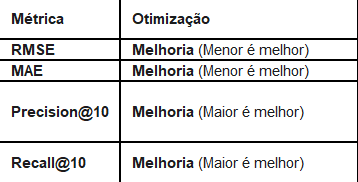

In [5]:
# --- AVALIAÇÃO QUANTITATIVA DO SVD OTIMIZADO ---
# Re-dividir os dados para obter o 'testset' (Necessário para a avaliação)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

print("\n--- 4.1. AVALIAÇÃO SVD OTIMIZADO ---")
predictions_optimized = algo_svd_otimizado.test(testset)

rmse_opt = accuracy.rmse(predictions_optimized, verbose=False)
mae_opt = accuracy.mae(predictions_optimized, verbose=False)

k_val = 10
rating_threshold = 4.0
precision_opt, recall_opt = precision_recall_at_k(predictions_optimized, k=k_val, threshold=rating_threshold)

print(f"✅ SVD Otimizado - RMSE: {rmse_opt:.4f}")
print(f"✅ SVD Otimizado - MAE: {mae_opt:.4f}")
print(f"✅ SVD Otimizado - Precision@{k_val}: {precision_opt:.4f}")
print(f"✅ SVD Otimizado - Recall@{k_val}: {recall_opt:.4f}")

# (Use os seus resultados do script original para esta comparação manual)
print("\n--- COMPARATIVO COM A VERSÃO ORIGINAL ---")
print(f"➡️ SVD Original - RMSE: 0.8820 (Seus resultados iniciais)")
# ... (Adicione aqui suas outras métricas originais para uma comparação clara)


--- 4.1. AVALIAÇÃO SVD OTIMIZADO ---
✅ SVD Otimizado - RMSE: 0.6817
✅ SVD Otimizado - MAE: 0.5300
✅ SVD Otimizado - Precision@10: 0.4733
✅ SVD Otimizado - Recall@10: 0.3764

--- COMPARATIVO COM A VERSÃO ORIGINAL ---
➡️ SVD Original - RMSE: 0.8820 (Seus resultados iniciais)


3. Filtragem Baseada em Conteúdo (TF-IDF) - O Boost Semântico

O método de conteúdo é usado para calcular a similaridade entre os filmes, baseado em seus metadados (gêneros no seu caso).

3.1. Criação da Matriz de Similaridade

    TfidfVectorizer: Transforma os textos da coluna rich_content (gêneros) em uma matriz numérica (vetores). Ele dá mais peso (importância) a termos que aparecem em poucos filmes (gêneros raros) e menos peso a termos que aparecem em muitos filmes (gêneros comuns).

    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix): Calcula a Similaridade de Cossenos entre todos os pares de filmes. O resultado é uma matriz gigante onde cada célula $[i, j]$ indica quão similar é o filme $i$ ao filme $j$ (um valor entre 0 e 1).

    indices: Cria um mapa que permite buscar rapidamente o índice de um filme na matriz de similaridade a partir do seu título.

In [6]:
# FILTRAGEM BASEADA EM CONTEÚDO OTIMIZADA (TF-IDF aprimorado)

print("\n--- Criando Matriz TF-IDF a partir de Conteúdo Rico ---")
# Usamos 'rich_content' (que no momento é só gêneros)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['rich_content'])

print("--- Calculando Matriz de Similaridade de Cossenos ---")
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Mapa de índices (title_clean -> índice)
indices = pd.Series(movies_df.index, index=movies_df['title_clean'])
indices = indices[~indices.index.duplicated(keep='first')]


--- Criando Matriz TF-IDF a partir de Conteúdo Rico ---
--- Calculando Matriz de Similaridade de Cossenos ---


4. O Modelo Híbrido (Re-ranking)

A função get_hybrid_recommendations é a implementação da sua estratégia híbrida, que usa uma técnica chamada Re-ranking Ponderado:

    1. Identificação do Gosto de Conteúdo (Item Favorito):

        O script encontra todos os filmes que o usuário avaliou com uma nota muito alta ($\ge 4.5$, definido pelo rating_threshold).

        Ele calcula o vetor de similaridade médio desses filmes favoritos (sim_scores_favorite_avg). Isso representa o "perfil de gosto de conteúdo" do usuário, baseado em seus filmes de maior sucesso.

    2. Geração de Candidatos (SVD):

        O script gera uma lista de candidatos (filmes que o usuário ainda não viu) e obtém suas previsões de nota ($S_{SVD}$) usando o modelo algo_svd_otimizado.

        Ele se concentra apenas nos 200 candidatos mais bem cotados pelo SVD para otimizar o processamento.

    3. Cálculo do Score Híbrido (Re-ranking):

        Para cada candidato, o score SVD ($S_{SVD}$) é ajustado:
            $$\text{Score Híbrido} = S_{SVD} + (\text{Similaridade Média de Conteúdo} \times \text{Peso})$$

        A Similaridade Média de Conteúdo mede o quão parecido o filme candidato é com o perfil de gosto médio do usuário.

        O content_weight (padrão $0.5$) define o quanto a similaridade de conteúdo pode "impulsionar" (boost) a previsão original do SVD. Um filme com alta similaridade de conteúdo terá seu score elevado, ganhando posições no ranking final.


In [7]:
# FUNÇÃO DE RECOMENDAÇÃO HÍBRIDA

def get_hybrid_recommendations(user_id, n=10, content_weight=0.5, rating_threshold=4.5):
    """
    Gera recomendações híbridas (SVD + Conteúdo).
    
    content_weight: Ponderação do boost de similaridade de conteúdo.
    rating_threshold: Nota mínima para um filme ser considerado "favorito" para o boost.
    """
    
    # --- 1. Obter Média de Similaridade de Conteúdo (Filmes Favoritos) ---
    sim_scores_favorite_avg = None
    
    # Filmes avaliados pelo usuário com nota alta
    user_high_ratings = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['rating'] >= rating_threshold)]
    
    if not user_high_ratings.empty:
        
        # Obter os IDs de índice dos filmes favoritos
        favorite_movie_ids = user_high_ratings['movieId'].unique()
        favorite_titles = movies_df[movies_df['movieId'].isin(favorite_movie_ids)]['title_clean']
        
        # Obter os índices no 'cosine_sim' para esses filmes
        favorite_indices = [indices[title] for title in favorite_titles if title in indices]
        
        if favorite_indices:
            # Calcular a média dos vetores de similaridade dos filmes favoritos
            sim_vectors = cosine_sim[favorite_indices]
            sim_scores_favorite_avg = np.mean(sim_vectors, axis=0) # Média por coluna (item)
        
    if sim_scores_favorite_avg is None:
        print(f"Não foi possível encontrar filmes favoritos (>{rating_threshold}) para o usuário {user_id}. Usando SVD puro.")
        
    
    # --- 2. Gerar Candidatos (SVD) ---
    movies_rated = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
    all_movie_ids = movies_df['movieId'].unique()
    movies_to_predict = [mid for mid in all_movie_ids if mid not in movies_rated]
    
    svd_predictions = []
    # Olhar apenas para os top 200 para otimizar o cálculo de re-ranking
    for movie_id in movies_to_predict:
        pred = algo_svd_otimizado.predict(uid=user_id, iid=movie_id)
        svd_predictions.append((movie_id, pred.est))
        
    svd_predictions.sort(key=lambda x: x[1], reverse=True)
    
    # --- 3. Re-ranking (Híbrido) ---
    hybrid_scores = []
    
    # Vamos olhar para os 100 melhores candidatos do SVD
    for movie_id, svd_score in svd_predictions[:200]: 
        
        hybrid_score = svd_score
        
        if sim_scores_favorite_avg is not None:
            try:
                # Encontrar o índice deste filme candidato
                movie_title = movies_df.loc[movies_df['movieId'] == movie_id]['title_clean'].iloc[0]
                idx_candidato = indices[movie_title]
                
                # Obter a similaridade média de conteúdo
                content_similarity = sim_scores_favorite_avg[idx_candidato]
                
                # Aplicação do "boost" ponderado
                hybrid_score = svd_score + (content_similarity * content_weight) 
                
            except (KeyError, IndexError):
                pass
                
        hybrid_scores.append((movie_id, hybrid_score))
        
    # --- 4. Finalizar ---
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    
    top_n_movie_ids = [mid for mid, score in hybrid_scores[:n]]
    
    return movies_df[movies_df['movieId'].isin(top_n_movie_ids)][['movieId', 'title_clean', 'genres']]

Resultado Final:

    Os filmes são reordenados com base no Score Híbrido.

    O Top 10 (n=10) é retornado.

O bloco final (EXECUÇÃO E TESTE) é apenas a chamada de demonstração dessa função para o user_example_id = 50.

In [8]:
# EXECUÇÃO E TESTE

user_example_id = 50 
print(f"\n--- Top 10 Recomendações HÍBRIDAS OTIMIZADAS para o Usuário {user_example_id} ---")

final_recommendations = get_hybrid_recommendations(user_example_id, n=10, content_weight=0.5, rating_threshold=4.5)
print(final_recommendations)


--- Top 10 Recomendações HÍBRIDAS OTIMIZADAS para o Usuário 50 ---
      movieId                                title_clean       genres
796      1041                             Secrets & Lies        Drama
841      1104                  Streetcar Named Desire, A        Drama
883      1178                             Paths Of Glory    Drama|War
918      1217                                        Ran    Drama|War
1649     2202                                   Lifeboat    Drama|War
2411     3201                           Five Easy Pieces        Drama
2582     3451               Guess Who'S Coming To Dinner        Drama
4046     5747                                  Gallipoli    Drama|War
4396     6460                    Trial, The (Procès, Le)        Drama
9618   177593  Three Billboards Outside Ebbing, Missouri  Crime|Drama


In [12]:
import pickle
import numpy as np
from surprise.dump import dump

# 1. Salvar o Modelo SVD
# OBS: O caminho deve ser acessível pelo app.py depois
dump(r'../model_artifacts/algo_svd_otimizado.pickle', algo_svd_otimizado)

# 2. Salvar o DataFrame de Filmes (incluindo title_clean e genres)
movies_df[['movieId', 'title', 'title_clean', 'genres']].to_csv(
    r'../model_artifacts/movies_for_app.csv', index=False
)

# 3. Salvar a Matriz de Similaridade de Cossenos (numpy)
np.save(r'../model_artifacts/cosine_sim_matrix.npy', cosine_sim)

# 4. Salvar o mapa de índices (pandas Series)
indices.to_pickle(r'../model_artifacts/indices.pickle')

print("Artefatos do modelo salvos com sucesso!")

Artefatos do modelo salvos com sucesso!
